In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR


import torch.nn.functional as F
import torchvision.transforms as T

from tqdm import tqdm


from torch_geometric.data import Dataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv,GraphConv, ChebConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import pyproj

PROJ = pyproj.Proj(proj='stere',  a=6378273, b=6378273, lon_0=-45, lat_0=90, lat_ts=90)

##Adding src path to get our code
import sys
sys.path.append('../src')
from ice_graph.ice_graph import nextsim_data

## Sea Ice ML - Training and data handling example

Here it is presented how to create custom graphs centered on neXTSIM elements, convert them into pytorch geometric data classes and train a simple GNN to predict trajectories.

In [2]:
#Load the files (Note, you need to clone the repo first -- upper cells)
file_graphs = [dict(np.load(f'../example_data/{file}')) for file in sorted(os.listdir('../example_data')) if file[-3:]=='npz']

In [3]:
ig = nextsim_data(
    file_graphs,
    node_element_features =
        ['M_VT_x','M_VT_y',
        'M_wind_x',
        'M_wind_y',
        'M_ocean_x',
        'M_ocean_y',
        'x',
        'y']
)
element_graphs = ig.element_data_list

### Code implementation
##### To be cleaned an implemented into project structure

In [5]:
def get_trajectories(
    element_graphs:list[dict],
    element_index:int,
    iter=None
    ):
    """
    Given a list of element graphs, return the trajectories of the nodes that compose the element

    Arguments:
        element_graphs : list
            List of element graphs
        element_index : int
            index to of element to track
        iter: int
            iterations to track, if None, compute all trajectory
    returns:
        trajectories : torch.tensor"""

    #Get target element's nodes
    nodes = element_graphs[0]['t'][element_index]
    #Get nodes indeces
    node_i = element_graphs[0]['i'][nodes]

    x,y = [],[]
    for i,hour in enumerate(element_graphs):
        if iter is None or i<iter:
            #we need to retrieve the position (idx) of each node by index i
            #having 3 separate index is necesary to keep track of each in x,y
            idx_1 = np.where(hour['i']==node_i[0])[0]
            idx_2 = np.where(hour['i']==node_i[1])[0]
            idx_3 = np.where(hour['i']==node_i[2])[0]
            if len(idx_1)>0 and len(idx_2)>0 and len(idx_3)>0:
                    x.append(hour['node_x'][[idx_1,idx_2,idx_3]])
                    y.append(hour['node_y'][[idx_1,idx_2,idx_3]])


    x = np.stack(x)
    y = np.stack(y)

    trajectories = torch.stack([torch.tensor(x),torch.tensor(y)],dim=0).squeeze()
    return trajectories

Number of neighbours: (40,)


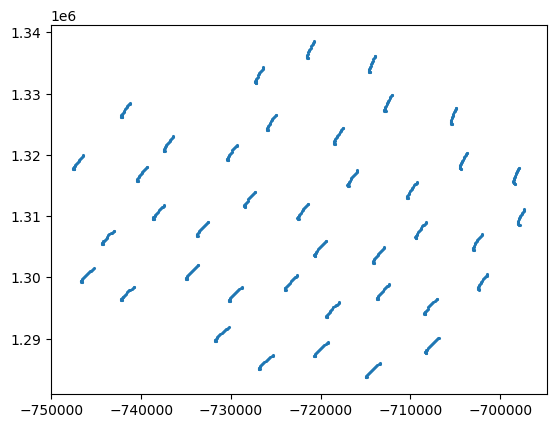

In [4]:
#plot trajectories over neightbouring elements
element_index = 6504
iterations = 20
n_neighbours = 40
#Get closest elements by distance
neighbours = ig.get_closer_neighbours(element_index,n_neighbours)

print("Number of neighbours:",neighbours.shape)
#get future trajectories of those elements
trajectories = []
for i in neighbours:
    trajectory = ig.get_trajectories(time_index=1,element_index=i, iter=iterations).mean(dim=-1)#mean computes the centroid of the nextsim nodes trajectories
    trajectories.append(trajectory)
    
#Discard shorter trajectories due to element dissapearing
trajectories = [t for t in trajectories if t.shape[1]==iterations]
t = torch.concat(trajectories,dim=-1)
#plot all trajectories
plt.scatter(t[0,:],t[1,:],s=6,marker='.')

Number of neighbours: (40,)


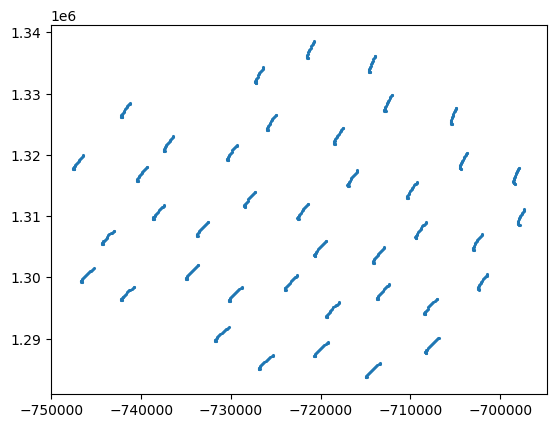

In [6]:
#plot trajectories over neightbouring elements
element_index = 6504
graph = element_graphs[0]
x_center = graph['x'][element_index]
y_center = graph['y'][element_index]
iterations = 20
n_neighbours = 40

#Get closest elements by distance (not a graph-like implementation, but it works and its fast)
neighbours = np.argsort(np.sqrt((graph['x']-x_center)**2 + (graph['y']-y_center)**2))[:n_neighbours]

print("Number of neighbours:",neighbours.shape)
#get future trajectories of those elements
trajectories = []
for i in neighbours:
    trajectory = get_trajectories(element_graphs,element_index=i, iter=iterations).mean(dim=-1)#mean computes the centroid of the nextsim nodes trajectories
    trajectories.append(trajectory)
#Discard shorter trajectories due to element dissapearing
trajectories = [t for t in trajectories if t.shape[1]==iterations]
t = torch.concat(trajectories,dim=-1)
#plot all trajectories
plt.scatter(t[0,:],t[1,:],s=6,marker='.')

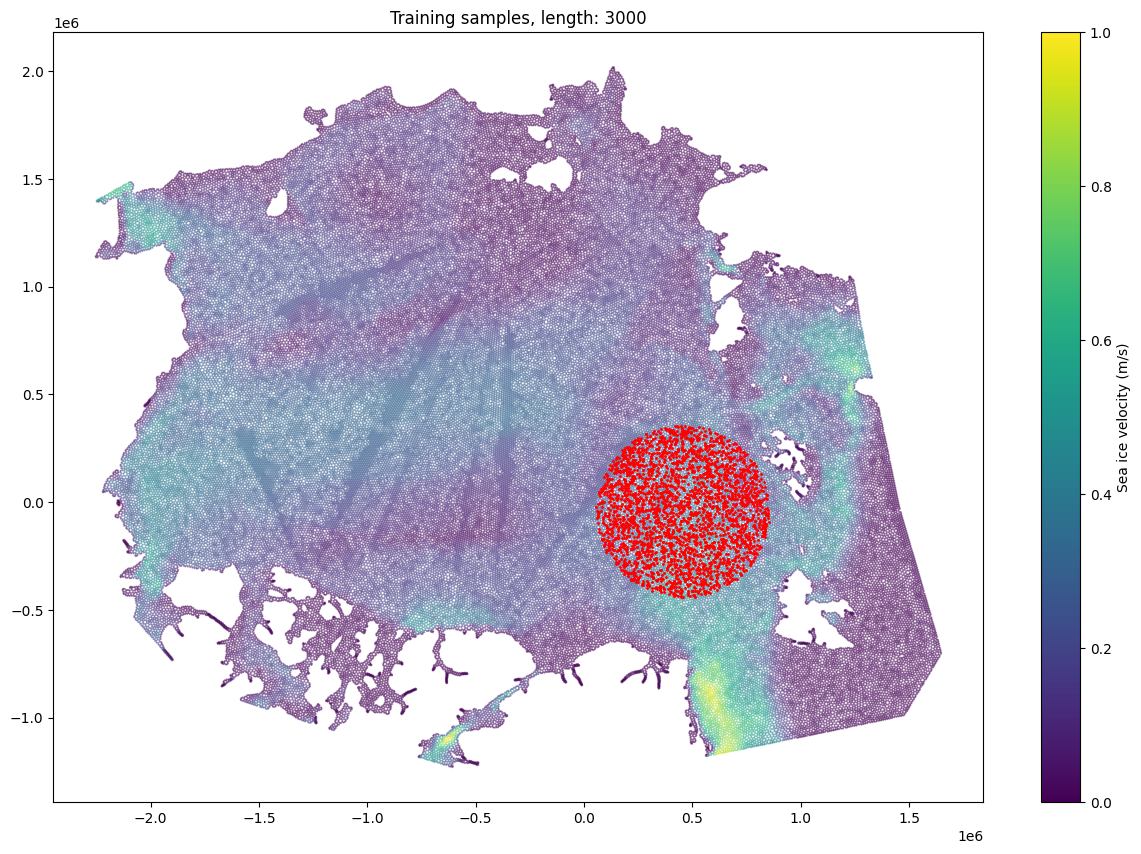

In [7]:
#Here we can generate samples from an hour snapshot to create a training dataset
#We can either select randomly or within a radious from a given element.
#seed for reproducibility
np.random.seed(42)
index_graph = 12 #index of element graph to fetch samples
hour_graph = element_graphs[index_graph]

#Define training smaples By distance or randomly
#RANDOM
n_generations = 3000
#we start sampling from 5000 to avoid element on the boundaries
#samples = np.random.randint(5000,len(hour_graph['t']),n_generations)
#BY DISTANCE
radius = 400000 #meters
element_index = 27500
x_center = hour_graph['x'][element_index]
y_center = hour_graph['y'][element_index]
samples = np.where(np.sqrt((hour_graph['x']-x_center)**2 + (hour_graph['y']-y_center)**2)<radius)[0]
samples = np.random.choice(samples,n_generations)
len(samples)


plt.figure(figsize=(15,10))
vel_norm = np.sqrt(hour_graph['M_VT_x']**2 + hour_graph['M_VT_y']**2)
plt.scatter(hour_graph['x'],hour_graph['y'],c=vel_norm, s= 3 ,marker='.',linewidths=.7,alpha=.4)
plt.title("Training samples, length: "+str(len(samples)))
plt.scatter(hour_graph['x'][samples],hour_graph['y'][samples], color='red',s= 7 ,marker='.',linewidths=.7)
plt.colorbar(label='Sea ice velocity (m/s)')


In [7]:
PROJ(x_center,y_center,inverse=True)

(39.57439017398445, 85.87788360933271)

In [30]:

#Data samples generation
#Ideas ->  create a specific class for this for element graphs management
training_graph_list = []
#feature_list = ['Damage','Concentration', 'M_wind_x', 'M_wind_y', 'x', 'y']
feature_list = ['Damage', 'Concentration', 'Thickness', 'Sigma_0', 'Sigma_1', 'M_VT_x', 'M_VT_y', 'M_wind_x', 'M_wind_y', 'M_ocean_x', 'M_ocean_y', 'x', 'y']
target_iter = 5 #trajectory lenght

for element in tqdm(samples,"Generating dataset"):

    #get the center of the element and find all neighbours within a radius of r
    x_center = hour_graph['x'][element]
    y_center = hour_graph['y'][element]
    neighbours = np.argsort(np.sqrt((hour_graph['x']-x_center)**2 + (hour_graph['y']-y_center)**2))[:4]

    #get the next pos of target nodes
    target_coords = get_trajectories(element_graphs[index_graph:],element,target_iter+1).mean(dim=-1)[:,1:].flatten().to(torch.float32)/1000 #tokm?
    element_coords = np.array([x_center,y_center])/1000 #tokm
    y = (element_coords,target_coords)

    if target_coords.shape[0] != target_iter*2:
        continue #skip nodes / elements that disapear

    #concat all node features sequentially (following index(t)) in a tensor
    features = []
    idx_list = []
    for key,item in hour_graph.items():
        if key in feature_list:
            idx_list.append(key)
            if key in ['x','y']:
              coords = item[neighbours]/1000 #tokm
              features.append(torch.tensor(np.array([coords]))) #fecth only the neighbours
            else:
              features.append(torch.tensor(np.array([item[neighbours]]))) #fecth only the neighbours
    node_features = torch.cat(features).t().to(torch.float32)

    #get t index of neighbours
    neighbours_t = hour_graph['t'][neighbours]
    #compute all adjacents edges #slow
    edge_list = []
    for i,element in enumerate(neighbours_t):
        adjacents = []
        for node in element:
            adjacents += list(np.where(np.isin(neighbours_t,node))[0]) #adjacents per node
        adjacents_edges = [[i,j] for j in np.unique(adjacents) if j!=i] #pairs of all adj edges by element index
        edge_list += adjacents_edges
    edges = torch.tensor(edge_list).t()


    #Now we need to consult x,y coordinates of each node of the edges and compute the edge distance
    # and we stack it as a 2xE (2 for each edge end, E as number of edges)
    coord_idx= [i for i,key in enumerate(idx_list) if key in ['x','y']]
    if len(coord_idx)==2:
        edges_coordinates = [
            torch.stack(
                [
                    node_features[edge_row][:,coord_idx[0]],
                    node_features[edge_row][:,coord_idx[1]]
                ]
            )
            for edge_row in edges
        ]
        #we also need to stack the node coordinates for the pos attribute
        positions = torch.stack(
            [
                node_features[:,coord_idx[0]],
                node_features[:,coord_idx[1]]
            ]
        )
    else:
        raise ValueError("Unable to find coordinates for nodes in graph mesh. \nDid you include it in the feature list?")

    #now we can compute the norm of each edge vector using torch api
    # unsqueeze to match [num_edges, num_edge_features] shape
    edge_attr = torch.norm(edges_coordinates[1] - edges_coordinates[0],dim=0).unsqueeze(dim=-1).to(torch.float32)/1000#tokm
    
    #distance map?
    #distance_map = torch.norm(positions.t()-element_coords,dim=1).to(torch.float32)
    #idx_list.append('distance_map')
    #node_features = torch.cat([node_features,distance_map.unsqueeze(dim=-1)],dim=-1)

    #Now we can create our torch-geometric graph using the "Data" class
    ice_graph = Data(x=node_features, edge_index=edges, edge_attr=edge_attr,pos=positions, y=y)

    training_graph_list.append(ice_graph)

print("\nNumber of samples:",len(training_graph_list)) #note some less than the inital number due to deleted nodes

Generating dataset: 100%|██████████| 3000/3000 [00:15<00:00, 196.30it/s]


Number of samples: 2969


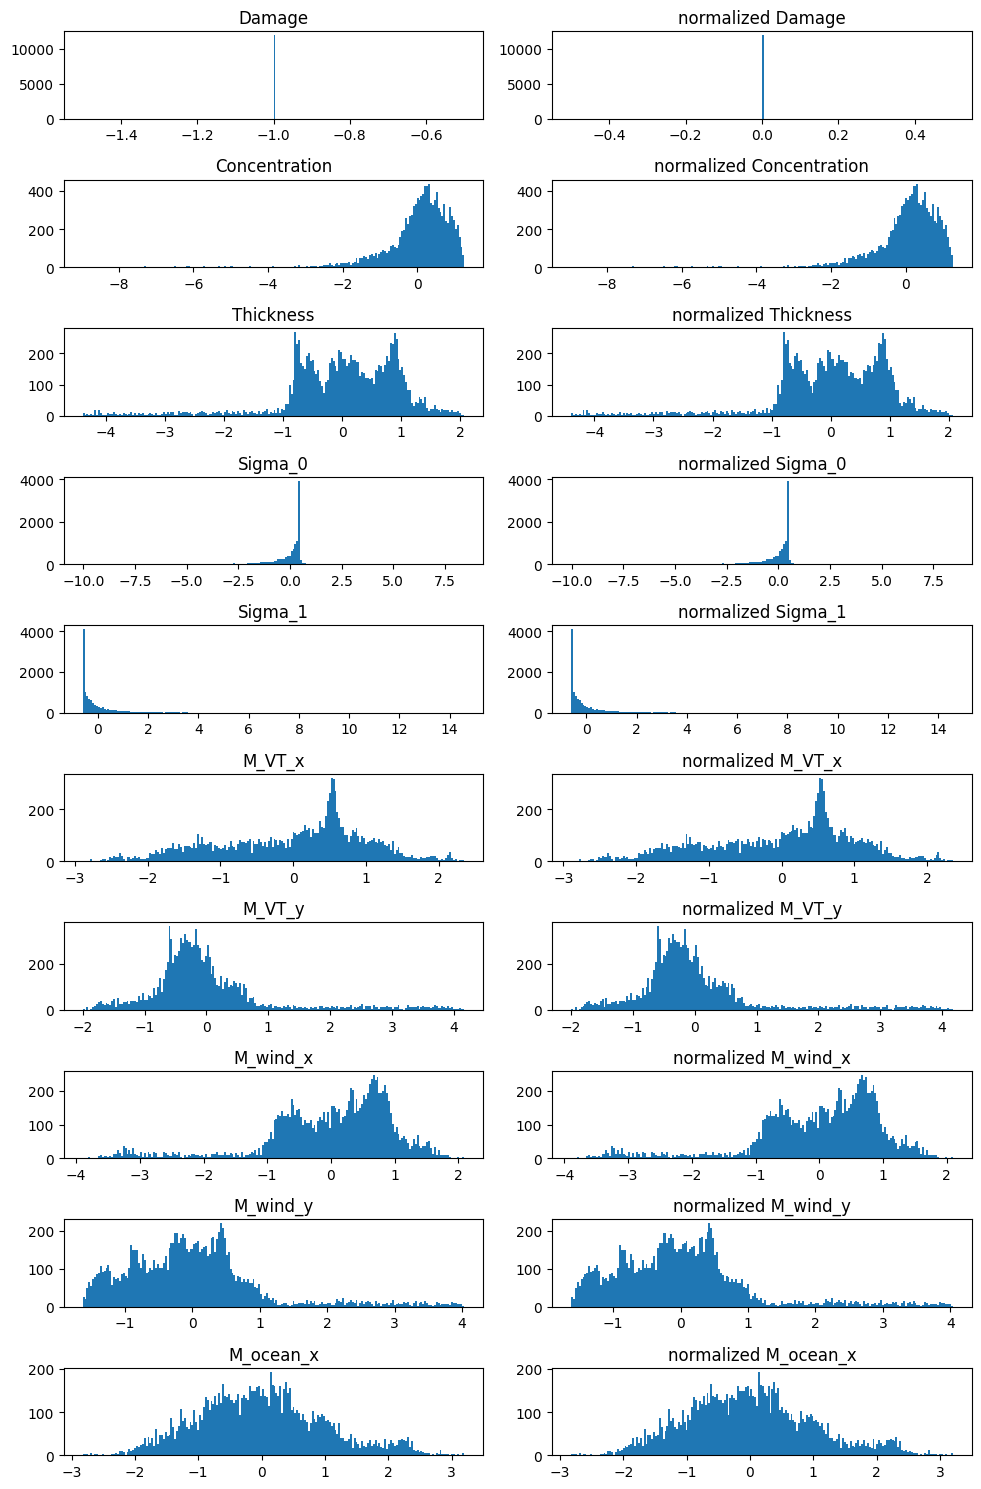

In [36]:
all_features_tensor = torch.stack([graph.x for graph in training_graph_list])
epsilon = 1e-10 #avoid /0
std_per_channel = all_features_tensor.std(dim=[0,1]) + epsilon
mean_per_channel = all_features_tensor.mean(dim=[0,1]) + epsilon
transfrom = T.Normalize(mean=mean_per_channel,std=std_per_channel)
normalized_features = transfrom(all_features_tensor.moveaxis(-1,0)).moveaxis(0,-1)

#insert back the normalized features into the graphs
for i,graph in enumerate(training_graph_list):
    graph.x = normalized_features[i,:,:]


fig,axs =  plt.subplots(10,2,figsize=(10,15))
for i in range(10):

    axs[i,0].set_title(idx_list[i])
    axs[i,0].hist(all_features_tensor[:,:,i].flatten(),bins=200)

    axs[i,1].set_title("normalized "+idx_list[i])
    axs[i,1].hist(normalized_features[:,:,i].flatten(),bins=200)
plt.tight_layout()

In [19]:
#Dataset: serves to fetch graph data on dataloaders or training loop. Its a standard torch class to manage information, transfrom and iterate over it

class Ice_graph_dataset(Dataset):
    def __init__(self, data_list, normalize = True):
        super(Ice_graph_dataset, self).__init__()

        # List of graphs
        self.data_list = data_list
        self.normalize = normalize

        #standarize (z-score) all features --> usually super important for training.
        #Right now is not working, loss divergess on normalize=True.
        #I beileve I should leave out position x,y from normalizaiton
        #std and mean are compute per feature across all the samples
        if self.normalize:

            all_features_tensor = torch.stack([graph.x for graph in data_list])
            epsilon = 1e-6 #avoid /0
            std_per_channel = all_features_tensor.std(dim=[0,1]) + epsilon
            mean_per_channel = all_features_tensor.mean(dim=[0,1]) + epsilon
            self.transfrom = T.Normalize(mean=mean_per_channel,std=std_per_channel)

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        data = self.data_list[idx]
        #normalization is applied before fetching the data instances
        if self.normalize:
            data.x = self.transfrom(data.x.unsqueeze(dim=0).moveaxis(-1,0)).squeeze().moveaxis(0,-1)
        return data


#really simple model to start
#idea: reduce inital complexity - if the problem is well formulated and data well procceses a simple model should perform okey-ish
class GCNN_node(nn.Module):

    def __init__(self, num_features, hidden_channels, output_size):
        super(GCNN_node, self).__init__()
        # conv layers as a test [WIP]
        self.conv1 = ChebConv(num_features, hidden_channels,K=1)
        
        self.fc = nn.Linear(hidden_channels, output_size)

    def forward(self, x, edge_index,edge_attr):
        x = self.conv1(x, edge_index,edge_attr)
        x = F.relu(x)

        # Global pooling to aggregate node features (... not sure how elegant)
        x = torch.mean(x, dim=0)

        # Fully connected layer for the final output
        x = self.fc(x)


        return x

In [32]:
# Dataset creation, model definition and training
# Note in here we are only overfitting ot study the fesiability of the approach

ice_dataset = Ice_graph_dataset(training_graph_list, normalize=False)
example_graph = next(iter(ice_dataset)) #just to get the num_features

num_features = example_graph.x.shape[-1]  # Node feature dimension
hidden_channels = 12
num_classes = example_graph.y[-1].shape[0] # trajectory lenght *2, since we have x,y. #CAREFULL!

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNN_node(num_features, hidden_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
mse = nn.MSELoss()

#usefull to avoid local minimas
#scheduler = ReduceLROnPlateau(optimizer, 'min')
scheduler = ExponentialLR(optimizer, gamma=0.9)
# Set the model to training model
model.train()

# Define the number of epochs
num_epochs = 50

# Iterate over the dataset for the specified number of epochs
loss_per_epoch = []
for epoch in range(num_epochs):
    # Initialize the total loss for the epoch
    total_loss = 0

    # Iterate over the training graph list
    for graph in ice_dataset:
        # Move the graph to the device
        graph = graph.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform a forward pass
        output = model(graph.x, graph.edge_index, graph.edge_attr)
        #print(output.shape)
        # Compute the loss
        loss = mse(output, graph.y[-1]) #note in meters... not nice, should be also standarize(?) large losses might create unstable gradients

        # Backpropagation
        loss.backward()
        # Update the parameters
        optimizer.step()
        # Add the loss to the total loss for the epoch
        total_loss += loss.item()

    #Compute the average loss for the epoch
    avg_loss = total_loss / len(training_graph_list)
    scheduler.step()
    loss_per_epoch.append(avg_loss)
    # Print the average loss for the epoch
    if epoch%5==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

Epoch 1/50, Average Loss: 1690.1235
Epoch 6/50, Average Loss: 80.7657
Epoch 11/50, Average Loss: 33.0466
Epoch 16/50, Average Loss: 14.8267
Epoch 21/50, Average Loss: 4.7012
Epoch 26/50, Average Loss: 1.8476
Epoch 31/50, Average Loss: 0.8500
Epoch 36/50, Average Loss: 0.5067
Epoch 41/50, Average Loss: 0.3500
Epoch 46/50, Average Loss: 0.2778


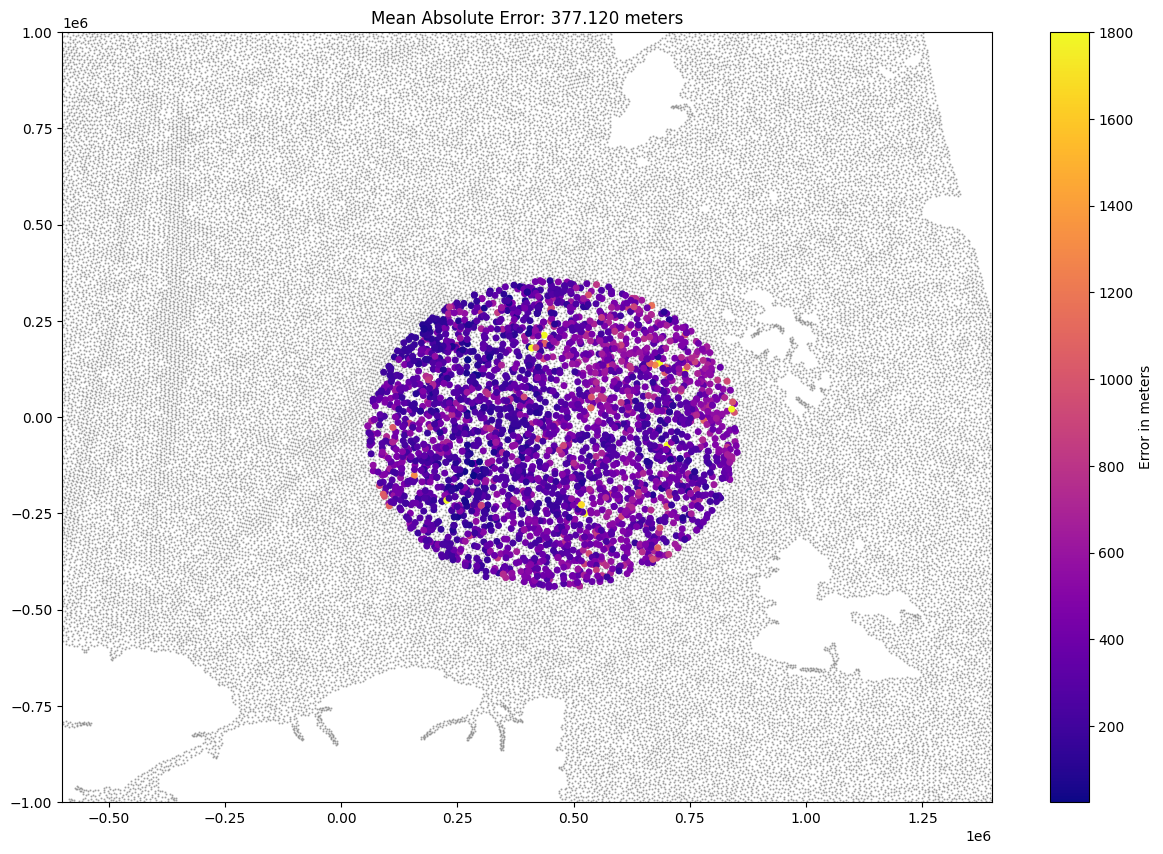

In [33]:
mae =  nn.L1Loss()
lossess = []
all_coords = []
for graph in ice_dataset:
        graph = graph.to(device)
        output = model(graph.x, graph.edge_index, graph.edge_attr)
        loss = mae(output, graph.y[-1]).to('cpu').detach().numpy() *1000
        coords = graph.y[0]
        lossess.append(loss)
        all_coords.append(coords)

avg_loss = np.array(lossess).mean()
all_coords = np.stack(all_coords)*1000

plt.figure(figsize=(15,10))
plt.scatter(hour_graph['x'],hour_graph['y'],c='grey', s= 3 ,marker='.',linewidths=.7,alpha=.5)
plt.scatter(all_coords[:,0],all_coords[:,1],c=np.clip(lossess,0,1800),s=16, cmap='plasma')
plt.xlim([-0.6e6, 1.4e6])
plt.ylim([-1e6, 1e6])
plt.title("Mean Absolute Error: "+str(avg_loss-1)[:7]+" meters")
plt.colorbar( label="Error in meters")


/tmp/ipykernel_30547/1687646107.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lossess)


Text(0.5, 0, 'MAE (meters)')

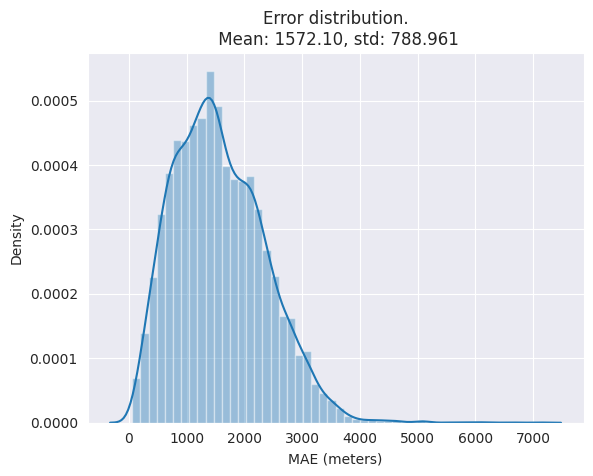

In [13]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(lossess)
plt.title(f"Error distribution.\n Mean: {str(avg_loss-1)[:7]}, std: {str(np.array(lossess).std())[:7]}")
plt.xlabel("MAE (meters)")


In [14]:
np.argsort(lossess)[-10:]

array([3488, 7026, 1457, 2741, 7468, 7711, 4412, 5675, 1208, 6508])

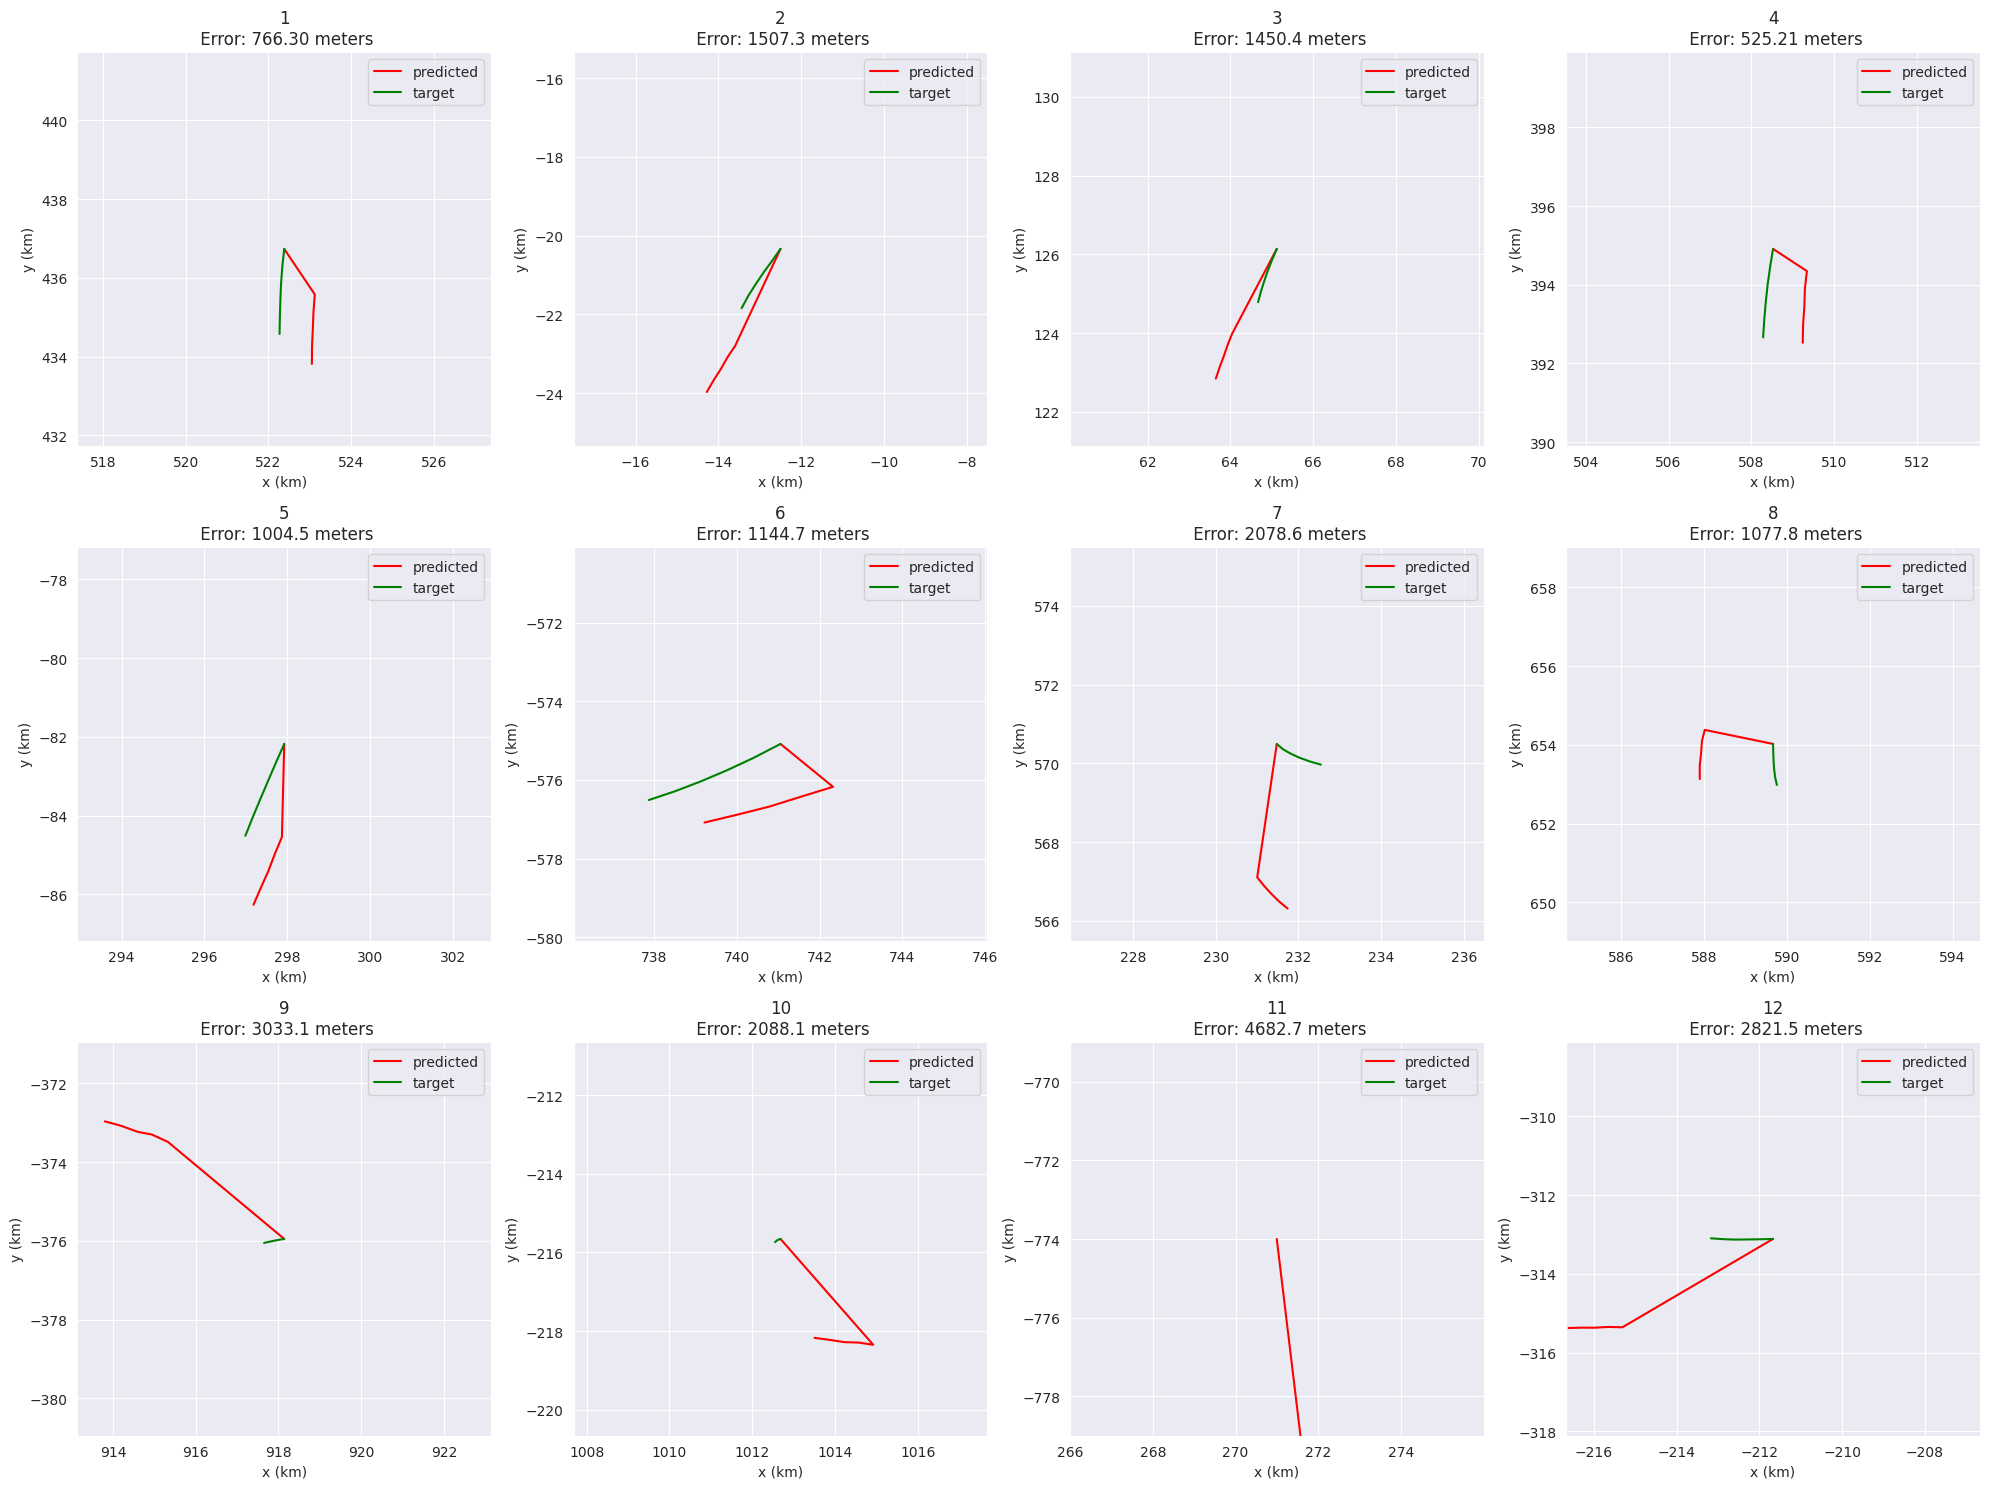

In [15]:
samples = [5875, 8340, 1775,  961,
           2222,7777,4444,1111,
           341, 3790, 4810, 2898]


fig,axs = plt.subplots(3,4,figsize=(20,15))

for i,element in enumerate(samples):
    graph = training_graph_list[element]
    init_coords = graph.y[0]
    graph = graph.to(device)

    output = model(graph.x, graph.edge_index, graph.edge_attr).cpu().detach().numpy()
    pred_x,pred_y = output[:target_iter],output[target_iter:]
    pred_x,pred_y = np.insert(pred_x,0,init_coords[0]), np.insert(pred_y,0,init_coords[1])

    target = graph.y[-1].cpu().detach().numpy()
    target_x,target_y = target[:target_iter],target[target_iter:]
    target_x,target_y = np.insert(target_x,0,init_coords[0]), np.insert(target_y,0,init_coords[1])

    error = mae(torch.tensor(output),torch.tensor(target)).item()*1000
    
    axs.flatten()[i].plot(pred_x,pred_y, c='red',label="predicted")
    axs.flatten()[i].plot(target_x,target_y, c='green',label="target")
    axs.flatten()[i].set_xlim([target_x[0]-5, target_x[0]+5]) # 10km
    axs.flatten()[i].set_ylim([target_y[0]-5, target_y[0]+5])
    axs.flatten()[i].legend()
    axs.flatten()[i].set_title(f"{i+1}\n Error: "+str(error)[:6]+" meters")
    axs.flatten()[i].set_xlabel("x (km)")
    axs.flatten()[i].set_ylabel("y (km)")
plt.tight_layout()



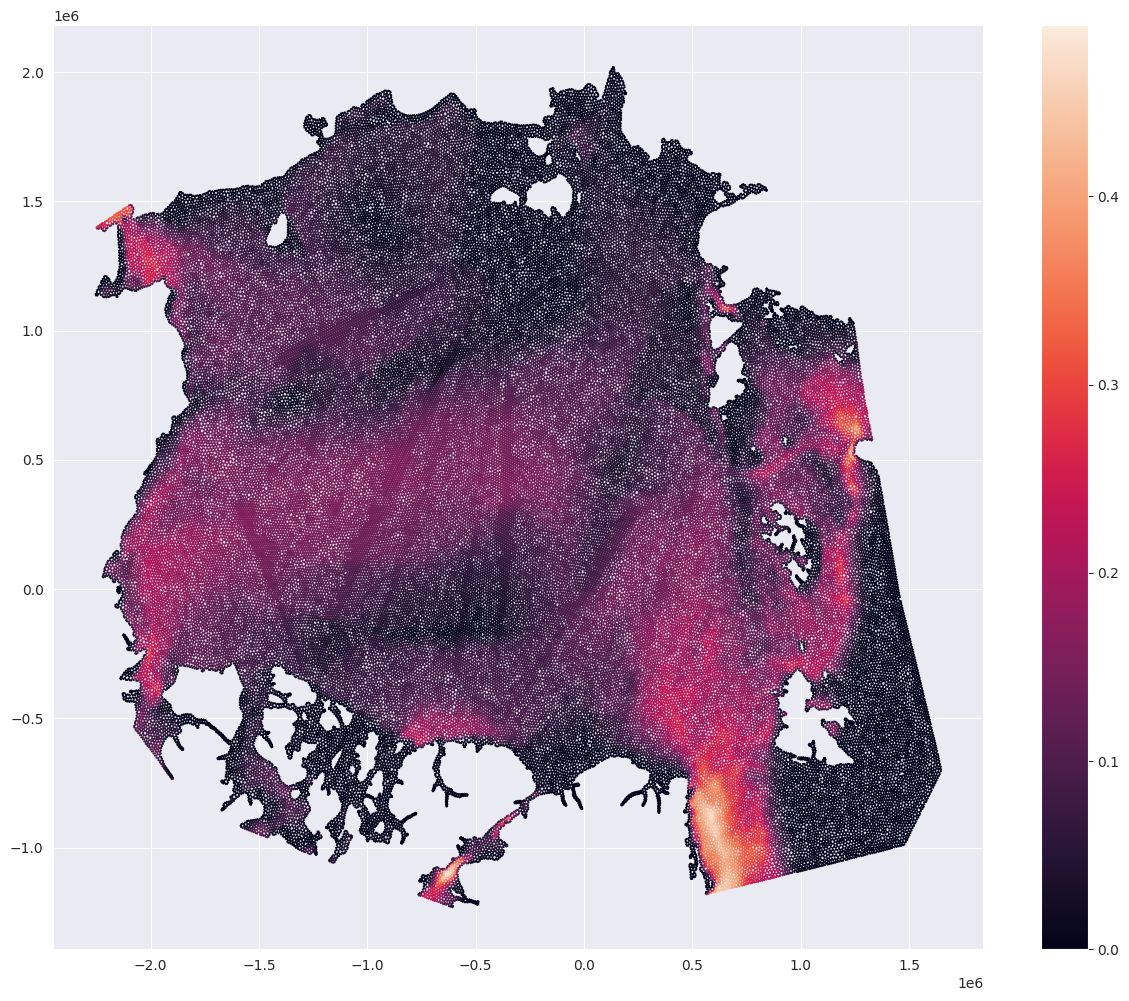

In [16]:
#plt element-interpolated data ?  --> looks cool!
element_graph = element_graphs[12]
plt.figure(figsize=(15,12))
vel_norm = np.sqrt(element_graph['M_VT_x']**2 + element_graph['M_VT_y']**2)
plt.scatter(element_graph['x'],element_graph['y'],c=vel_norm, s= 3 ,marker='.',linewidths=.7)
plt.colorbar()